In [247]:
import pandas as pd
import plotly.express as px
from plotly.colors import sequential

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots



DATE = "2019_01"


# Load the Agg dataset : source : FINAL/data/perCountry/agg_data_pairs_{DATE}.csv
agg_pairs_df = pd.read_csv(f'../data/perCountry/agg_data_pairs_{DATE}.csv')


<font color="yellow">agg_pairs is incorrect</font>

In [248]:
agg_pairs_df.columns

Index(['countryA', 'countryB', 'entryFlow', 'exitFlow'], dtype='object')

In [249]:
print(agg_pairs_df[agg_pairs_df['countryA'] == 'France'])

   countryA     countryB     entryFlow      exitFlow
31   France      Belgium  3.654710e+09  3.658168e+09
32   France       France  3.382401e+10  2.631997e+10
33   France      Germany  3.868704e+09  0.000000e+00
34   France       Norway  5.453810e+09  0.000000e+00
35   France        Spain  2.190778e+09  2.137785e+09
36   France  Switzerland  0.000000e+00  2.688735e+09


In [250]:
print(agg_pairs_df[agg_pairs_df['countryB'] == 'France'])

        countryA countryB     entryFlow      exitFlow
7        Belgium   France  3.654710e+09  3.658168e+09
32        France   France  3.382401e+10  2.631997e+10
41       Germany   France  1.934352e+09  0.000000e+00
105        Spain   France  2.190778e+09  2.137785e+09
108  Switzerland   France  0.000000e+00  2.688735e+09


# Transmission points data

Based on the code from buildDataPerCountry xhich is to be kept

BUT add differenciation between LNG and ground import/exports.

Ideas to combine maps : 
* Aggregate data for country interconnections based on Transmission points
* Keep the data for total imports/exports
* When selecting a country, display the proportion of entries/ exits per country and LNG if applicable

WHAT WE HAVE:
* Data per LNG point, which we combine for all points with the same country => All LNG entries per countries
* Data for each pair CountryA, CountryB 

HOW TO : 
* When a country is selected, create a pie chart with the total flow over the year for each pair with countryA as

In [251]:
from buildDataPerCountry import load_data, rename_columns

DATA_DIR = "../data"
date = "2019_01"

In [252]:
"""Load operational, points, operator points directions, and interconnections data."""
operational_df = pd.read_csv(f"{DATA_DIR}/opData/op_data_{date}.csv")
points_df = pd.read_csv(f"{DATA_DIR}/points_data.csv")
operator_points_directions_df = pd.read_csv(f"{DATA_DIR}/operator_points_dir.csv")
interconnections_df = pd.read_csv(f'{DATA_DIR}/interconnections_data.csv')


In [253]:
# TRANSMISSION KEYS
def filter_point_type(keyword,df,column):
    return df[df[column].str.contains(keyword)]

trans_points_df = filter_point_type("Transmission",points_df,'point_type')
print(trans_points_df.shape)


(240, 32)


In [254]:
def rename_columns(points_df, operational_df):
    """Rename columns to match the format of other datasets."""
    points_df.rename(columns={
        'point_key': 'pointKey',
        'point_label': 'pointLabel',
        'is_single_operator': 'isSingleOperator',
        'point_tooltip': 'pointTooltip',
        'point_eic_code': 'pointEicCode',
        'control_point_type': 'controlPointType',
        'tp_map_x': 'tpMapX',
        'tp_map_y': 'tpMapY',
        'point_type': 'pointType',
        'commercial_type': 'commercialType',
        'import_from_country_key': 'importFromCountryKey',
        'import_from_country_label': 'importFromCountryLabel',
        'has_virtual_point': 'hasVirtualPoint',
        'virtual_point_key': 'virtualPointKey',
        'virtual_point_label': 'virtualPointLabel',
        'has_data': 'hasData',
        'is_planned': 'isPlanned',
        'is_interconnection': 'isInterconnection',
        'is_import': 'isImport',
        'infrastructure_key': 'infrastructureKey',
        'infrastructure_label': 'infrastructureLabel',
        'is_cross_border': 'isCrossBorder',
        'eu_crossing': 'euCrossing',
        'is_invalid': 'isInvalid',
        'is_macro_point': 'isMacroPoint',
        'is_cam_relevant': 'isCamRelevant',
        'is_pipe_in_pipe': 'isPipeInPipe',
        'is_cmp_relevant': 'isCmpRelevant',
        'id': 'id',
        'data_set': 'dataSet',
        'url': 'url'
    }, inplace=True)

    operational_df.rename(columns={
        'direction_key': 'directionKey',
        'flow_status': 'flowStatus',
        'id_point_type': 'idPointType',
        'operator_key': 'operatorKey',
        'period_from': 'periodFrom',
        'period_to': 'periodTo',
        'period_type': 'periodType',
        'point_key': 'pointKey',
        'point_label': 'pointLabel',
        'tso_eic_code': 'tsoEicCode',
        'unit': 'unit',
        'value': 'value'
    }, inplace=True)

rename_columns(points_df, operational_df)


In [255]:
# MERGE

merged_df = operational_df.merge(points_df[['pointKey', 'pointLabel']], on='pointKey', how='left')
merged_df = merged_df.merge(interconnections_df[['pointKey', 'fromCountryLabel', 'toCountryLabel']], on='pointKey', how='left')    

In [256]:
print(merged_df.shape)
print(merged_df.columns)

(15146, 17)
Index(['Unnamed: 0', 'directionKey', 'flowStatus', 'id', 'idPointType',
       'operatorKey', 'periodFrom', 'periodTo', 'periodType', 'pointKey',
       'pointLabel_x', 'tsoEicCode', 'unit', 'value', 'pointLabel_y',
       'fromCountryLabel', 'toCountryLabel'],
      dtype='object')


In [257]:
# FILTER 

print(f'Size before filtering: {merged_df.shape}')
filtered_df = merged_df[(merged_df['directionKey'].isin(['entry', 'exit']))]
filtered_df = filtered_df[filtered_df['value'].notna()]
print(f'... Size after filtering: {filtered_df.shape}')

Size before filtering: (15146, 17)
... Size after filtering: (13688, 17)


In [258]:
print(filtered_df.isna().sum())

Unnamed: 0              0
directionKey            0
flowStatus              0
id                      0
idPointType         11025
operatorKey             0
periodFrom              0
periodTo                0
periodType              0
pointKey                0
pointLabel_x            0
tsoEicCode              0
unit                    0
value                   0
pointLabel_y         1130
fromCountryLabel     2910
toCountryLabel       2844
dtype: int64


In [259]:
# ADD COUNTRY INFO
# Now assume all directions are entries

filtered_df['fromCountry'] = filtered_df.apply(lambda row: row['fromCountryLabel'] if row['directionKey'] == 'entry' else row['toCountryLabel'], axis=1)
filtered_df['toCountry'] = filtered_df.apply(lambda row: row['toCountryLabel'] if row['directionKey'] == 'exit' else row['fromCountryLabel'], axis=1)
# filtered_df['operatorCountryCode'] = filtered_df['operatorKey'].str[:2]

# count = filtered_df[(filtered_df['toCountryLabel'].isna()) & (filtered_df['toCountry'].isna())].shape[0]
# print(count)

# count = filtered_df[(filtered_df['fromCountryLabel'].isna()) & (filtered_df['fromCountry'].isna())].shape[0]
# print(count)

# CONCLUSION : 151 and 195 points have both as NaNs so not worth it to add the country info

## NEW : Group by entries-exits

In [260]:
# NEW 
# TODO : filter only transmission points
filtered_df = filtered_df[filtered_df['pointKey'].isin(trans_points_df['point_key'])]
print(f'... Size after filtering: {filtered_df.shape}')

... Size after filtering: (6813, 19)


In [261]:
# NEW
entries_df = filtered_df[filtered_df['directionKey'] == 'entry']
exits_df = filtered_df[filtered_df['directionKey'] == 'exit']
print(f'... Size entries: {entries_df.shape}')
print(f'... Size exits: {exits_df.shape}')

... Size entries: (3314, 19)
... Size exits: (3499, 19)


In [262]:
print(entries_df.columns)

Index(['Unnamed: 0', 'directionKey', 'flowStatus', 'id', 'idPointType',
       'operatorKey', 'periodFrom', 'periodTo', 'periodType', 'pointKey',
       'pointLabel_x', 'tsoEicCode', 'unit', 'value', 'pointLabel_y',
       'fromCountryLabel', 'toCountryLabel', 'fromCountry', 'toCountry'],
      dtype='object')


In [263]:
# entries_df.isna().sum()
# exits_df.isna().sum()

NOTE : 

After summing up the amount of NaNs for country labels to and from, choose toCountryLabel as a reference since it has the least amount of NaNs

In [264]:
print(len(entries_df['toCountryLabel'].unique()))
print(len(exits_df['toCountryLabel'].unique()))

32
33


In [265]:
# NEW
# Group by Pair of countries
relevant_columns = ['fromCountryLabel', 'toCountryLabel', 'value']

grouped_entries_df = entries_df[relevant_columns].groupby(['fromCountryLabel','toCountryLabel']).sum().reset_index()
grouped_exits_df = exits_df[relevant_columns].groupby(['fromCountryLabel','toCountryLabel']).sum().reset_index()

In [296]:
get_data_for_country(grouped_entries_df,'Belgium')

,fromCountryLabel,toCountryLabel,entryValue
7,Belgium,Belgium,1.077562e+07
8,Belgium,France,3.654710e+09
9,Belgium,Germany,1.186307e+09
10,Belgium,Luxemburg,2.501077e+08
11,Belgium,Netherlands,4.998158e+09
12,Belgium,Norway,5.133876e+09
13,Belgium,United Kingdom,7.195581e+08
25,France,Belgium,3.654710e+09
30,Germany,Belgium,1.186307e+09
54,Luxemburg,Belgium,2.501077e+08


In [297]:
get_data_for_country(grouped_exits_df,'Belgium')

,fromCountryLabel,toCountryLabel,exitValue
6,Belgium,Belgium,1.077562e+07
7,Belgium,France,3.658168e+09
8,Belgium,Germany,1.186307e+09
9,Belgium,Luxemburg,2.814929e+08
10,Belgium,Netherlands,4.899066e+09
11,Belgium,Norway,0.000000e+00
12,Belgium,United Kingdom,7.186310e+08
25,France,Belgium,3.658168e+09
29,Germany,Belgium,1.186307e+09
57,Luxemburg,Belgium,2.814929e+08


TODO FROM HERE:
* For each pair, compute the total -> DONE
* Combine datasets
* Compare entries and exits

In [268]:
grouped_entries_df.rename(columns={'value': 'entryValue'}, inplace=True)
grouped_exits_df.rename(columns={'value': 'exitValue'}, inplace=True)

# Merge entries and exits data
combined_df = pd.merge(grouped_entries_df, grouped_exits_df, 
                       on=['fromCountryLabel', 'toCountryLabel'], 
                       how='outer').fillna(0)

combined_df['totalFlow'] = combined_df['entryValue'] - combined_df['exitValue']

In [269]:
get_data_for_country(combined_df,'Russia')

,fromCountryLabel,toCountryLabel,entryValue,exitValue,totalFlow
27,Estonia,Russia,2.270703e+08,0.0,2.270703e+08
59,Latvia,Russia,7.496338e+07,0.0,7.496338e+07
62,Lithuania,Russia,0.000000e+00,636912274.0,-6.369123e+08
84,Russia,Estonia,2.270703e+08,0.0,2.270703e+08
85,Russia,Finland,1.087223e+09,0.0,1.087223e+09
86,Russia,Latvia,7.496338e+07,0.0,7.496338e+07
87,Russia,Ukraine,2.923028e+10,0.0,2.923028e+10


In [270]:
print(combined_df.shape)
print(combined_df.columns)

(109, 5)
Index(['fromCountryLabel', 'toCountryLabel', 'entryValue', 'exitValue',
       'totalFlow'],
      dtype='object')


### NEW : Plotly Sankey diagram

In [271]:
list(set(combined_df['fromCountryLabel']).union(set(combined_df['toCountryLabel'])))

['Spain',
 'San Marino',
 'Serbia',
 'Morocco',
 'Libya',
 'Ukraine',
 'United Kingdom',
 'Romania',
 'Turkey',
 'Russia',
 'Slovenia',
 'Belgium',
 'Latvia',
 'Luxemburg',
 'Italy',
 'Greece',
 'Bulgaria',
 'Croatia',
 'Slovakia',
 'Belarus',
 'Austria',
 'Ireland',
 'France',
 'Poland',
 'Denmark',
 'Estonia',
 'Hungary',
 'Germany',
 'Finland',
 'Lithuania',
 'North Macedonia',
 'Netherlands',
 'Switzerland',
 'Portugal',
 'Czechia',
 'Norway',
 'Moldavia']

In [272]:
countries = ['Russia', 'Germany','Slovakia','Ukraine','Norway','Netherlands','Belarus','Poland','Litva','Latvia','Estonia','Finland','Sweden']

In [273]:
selected_df = combined_df[(combined_df['toCountryLabel'].isin(countries)) & (combined_df['fromCountryLabel'].isin(countries))]


In [274]:
import plotly.graph_objects as go

# List of unique country labels
# countries = list(set(combined_df['fromCountryLabel']).union(set(combined_df['toCountryLabel'])))

# Create a dictionary for index mapping
country_index = {country: i for i, country in enumerate(countries)}

# Prepare source, target, and values for the Sankey diagram
source_indices = [country_index[selected_df.loc[i, 'fromCountryLabel']] for i in selected_df.index]
target_indices = [country_index[selected_df.loc[i, 'toCountryLabel']] for i in selected_df.index]
entry_values = selected_df['entryValue']
exit_values = selected_df['exitValue']

# Prepare Sankey nodes and links
nodes = dict(label=countries)

links = dict(
    source=source_indices + target_indices,
    target=target_indices + source_indices,
    value=entry_values.tolist() + exit_values.tolist(),
    color=["blue"] * len(entry_values) + ["red"] * len(exit_values),
    customdata=["Entries"] * len(entry_values) + ["Exits"] * len(exit_values),
    hovertemplate='Flow Type: %{customdata}<br>Source: %{source.label}<br>Target: %{target.label}<br>Value: %{value}<extra></extra>'
)


In [275]:
# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=nodes,
    link=links
))

# Update the layout
fig.update_layout(
    title_text="Total Gas Flow Entries and Exits Between Countries",
    font_size=10,  
)

# Show the figure
fig.show()


### NEW : Compare pair A,B,entry to B,A,exit

In [276]:
# Reverse the country pairs and append to the combined dataframe
reverse_exits_df = combined_df[['toCountryLabel', 'fromCountryLabel', 'exitValue']].rename(
    columns={'toCountryLabel': 'fromCountryLabel', 'fromCountryLabel': 'toCountryLabel'}
)

reverse_exits_df = reverse_exits_df.groupby(['fromCountryLabel', 'toCountryLabel']).sum().reset_index()


In [277]:
merged_df = pd.merge(grouped_entries_df, reverse_exits_df, 
                     on=['fromCountryLabel', 'toCountryLabel'], 
                     how='outer').fillna(0)

# Rename columns for clarity
merged_df.rename(columns={'entryValue': 'Entries', 'exitValue': 'Exits'}, inplace=True)

# Make exits negative for visualization
merged_df['Exits'] = -merged_df['Exits']

In [278]:
get_data_for_country(merged_df,'Russia')

,fromCountryLabel,toCountryLabel,Entries,Exits
27,Estonia,Russia,2.270703e+08,-0.0
28,Finland,Russia,0.000000e+00,-0.0
59,Latvia,Russia,7.496338e+07,-0.0
84,Russia,Estonia,2.270703e+08,-0.0
85,Russia,Finland,1.087223e+09,-0.0
86,Russia,Latvia,7.496338e+07,-0.0
87,Russia,Lithuania,0.000000e+00,-636912274.0
88,Russia,Ukraine,2.923028e+10,-0.0
110,Ukraine,Russia,0.000000e+00,-0.0


In [279]:
# TOTAL GAS FLOW between countries

import plotly.express as px

# Melt the dataframe to have a long-form data suitable for plotly express
melted_df = merged_df.melt(id_vars=['fromCountryLabel', 'toCountryLabel'], 
                           value_vars=['Entries', 'Exits'], 
                           var_name='FlowType', 
                           value_name='Value')

# Create the bar chart
fig = px.bar(melted_df, 
             x='fromCountryLabel', 
             y='Value', 
             color='FlowType', 
             barmode='group',
             hover_data=['toCountryLabel'],
             labels={'fromCountryLabel': 'From Country', 'Value': 'Gas Flow (kWh/d)', 'FlowType': 'Flow Type'},
             title='Comparison of Total Gas Flow Entries and Exits Between Countries')

# Update layout to make the chart more readable
fig.update_layout(
    xaxis_title='From Country',
    yaxis_title='Gas Flow (kWh/d)',
    legend_title='Flow Type',
    yaxis=dict(tickformat='.2s')  # Format y-axis ticks for readability
)

# Show the figure
fig.show()


In [280]:
merged_df['countryPair'] = merged_df['fromCountryLabel'] + ' -> ' + merged_df['toCountryLabel']

In [281]:
merged_df.head()

,fromCountryLabel,toCountryLabel,Entries,Exits,countryPair
0,Austria,Austria,0.000000e+00,-1.606757e+08,Austria -> Austria
1,Austria,Germany,6.263972e+08,-2.763488e+09,Austria -> Germany
2,Austria,Hungary,1.591662e+09,-1.591659e+09,Austria -> Hungary
3,Austria,Italy,1.045794e+10,-1.045789e+10,Austria -> Italy
4,Austria,Slovakia,0.000000e+00,-4.084191e+10,Austria -> Slovakia


In [282]:
# Create a long-form DataFrame suitable for Plotly Express
long_df = pd.melt(merged_df, 
                  id_vars=['countryPair'], 
                  value_vars=['Entries', 'Exits'], 
                  var_name='FlowType', 
                  value_name='Value')

# Define custom color mapping
color_mapping = {'Entries': 'blue', 'Exits': 'red'}

# Create the bar chart
fig = px.bar(long_df, 
             x='countryPair', 
             y='Value', 
             color='FlowType', 
             color_discrete_map=color_mapping,
             labels={'countryPair': 'Country Pair', 'Value': 'Gas Flow (kWh/d)', 'FlowType': 'Flow Type'},
             title='Comparison of Total Gas Flow Entries and Exits Between Country Pairs')

# Update layout for better readability
fig.update_layout(
    barmode='group',
    xaxis_tickangle=-45,
    yaxis=dict(
        title='Gas Flow (kWh/d)',
        showgrid=True
    ),
    xaxis=dict(
        title='Country Pair',
        categoryorder='total descending'
    )
)

# Show the figure
fig.show()

In [283]:
diff_df = merged_df.copy()
print(f"Size before filtering: {diff_df.shape}")
diff_df = diff_df[['countryPair', 'Entries', 'Exits']]
diff_df = diff_df[(diff_df['Entries'] != 0) | (diff_df['Exits'] != 0)]
diff_df = diff_df[diff_df['countryPair'].apply(lambda x: x.split(' -> ')[0] != x.split(' -> ')[1])]
print(f"Size after filtering: {diff_df.shape}")
diff_df['Difference'] = diff_df['Entries'] + diff_df['Exits']

Size before filtering: (118, 5)
Size after filtering: (94, 3)


In [284]:
# Create a long-form DataFrame suitable for Plotly Express
long_df = pd.melt(diff_df, 
                  id_vars=['countryPair'], 
                  value_vars=['Entries', 'Exits','Difference'], 
                  var_name='FlowType', 
                  value_name='Value')

# Define custom color mapping
color_mapping = {
    'Entries': 'blue', 'Exits': 'red','Difference':'green'}

# Create the bar chart
fig = px.bar(long_df, 
             x='countryPair', 
             y='Value', 
             color='FlowType', 
             color_discrete_map=color_mapping,
             labels={'countryPair': 'Country Pair', 'Value': 'Gas Flow (kWh/d)','Difference':'Total diff' ,'FlowType': 'Flow Type'},
             title='Comparison of Total Gas Flow Entries and Exits Between Country Pairs')

# Update layout for better readability
fig.update_layout(
    barmode='group',
    xaxis_tickangle=-45,
    yaxis=dict(
        title='Gas Flow (kWh/d)',
        showgrid=True
    ),
    xaxis=dict(
        title='Country Pair',
        categoryorder='total descending'
    )
)


# Show the figure
fig.show()


Analysis : Most of them are on-par, except from the ones on the extremities

Inconsitencies come from the fact that data might be comming from only one of both parties

TODO : Use this graph but on the total entries/exits over the year

## IGNORE :  Add country info

In [285]:
# # ADD COUNTRY INFO
# # Now assume all directions are entries

# filtered_df['fromCountry'] = filtered_df.apply(lambda row: row['fromCountryLabel'] if row['directionKey'] == 'entry' else row['toCountryLabel'], axis=1)
# filtered_df['toCountry'] = filtered_df.apply(lambda row: row['toCountryLabel'] if row['directionKey'] == 'exit' else row['fromCountryLabel'], axis=1)
# filtered_df['operatorCountryCode'] = filtered_df['operatorKey'].str[:2]

In [286]:
# print(filtered_df.shape)
# print(filtered_df.columns)

In [287]:
# print(f"Entries from and to the same country : {filtered_df[filtered_df['fromCountry'] == filtered_df['toCountry']].shape}")

## Aggregate Data

In [288]:
print(combined_df.shape)
combined_df.columns

(109, 5)


Index(['fromCountryLabel', 'toCountryLabel', 'entryValue', 'exitValue',
       'totalFlow'],
      dtype='object')

In [289]:
get_data_for_country(combined_df,'Russia')

,fromCountryLabel,toCountryLabel,entryValue,exitValue,totalFlow
27,Estonia,Russia,2.270703e+08,0.0,2.270703e+08
59,Latvia,Russia,7.496338e+07,0.0,7.496338e+07
62,Lithuania,Russia,0.000000e+00,636912274.0,-6.369123e+08
84,Russia,Estonia,2.270703e+08,0.0,2.270703e+08
85,Russia,Finland,1.087223e+09,0.0,1.087223e+09
86,Russia,Latvia,7.496338e+07,0.0,7.496338e+07
87,Russia,Ukraine,2.923028e+10,0.0,2.923028e+10


(97, 3)
(93, 3)


,toCountryLabel,fromCountryLabel,revExit
0,Austria,Austria,1.606757e+08
1,Austria,Germany,1.601837e+09
2,Austria,Hungary,1.591659e+09
3,Austria,Italy,1.045789e+10
4,Austria,Slovakia,5.445588e+10


In [294]:
aggregated_df = pd.merge(grouped_entries_df, grouped_exits_df, 
        on=['fromCountryLabel', 'toCountryLabel'], 
        how='outer').fillna(0)
print(aggregated_df.shape)
aggregated_df = pd.merge(aggregated_df, reversed_exits,on = ['fromCountryLabel', 'toCountryLabel'], how='outer').fillna(0)
print(aggregated_df.shape)
aggregated_df = pd.merge(aggregated_df, reversed_entries,on = ['fromCountryLabel', 'toCountryLabel'], how='outer').fillna(0)

aggregated_df['totalFlow'] = aggregated_df['entryValue'] - aggregated_df['exitValue']



(109, 4)
(115, 5)


In [300]:
def reversed_info(grouped_entries_df, grouped_exits_df):
    reversed_exits = grouped_exits_df.copy()
    reversed_exits.rename(columns={'fromCountryLabel': 'toCountryLabel','toCountryLabel':'fromCountryLabel','exitValue':'revExit'}, inplace=True)

    reversed_entries = grouped_entries_df.copy()
    reversed_entries.rename(columns={'fromCountryLabel': 'toCountryLabel','toCountryLabel':'fromCountryLabel','entryValue':'revEntry'}, inplace=True)

    return reversed_exits, reversed_entries

In [311]:
def combine_pairs(aggregated_df):
    """ 
    Args : aggregated_df is a dataframe with the columns formCountryLabel, toCountryLabel, entryValue, exitValue
    """
    df = aggregated_df.copy()
    df['pairKey'] = df.apply(lambda row: tuple(sorted([row['fromCountryLabel'],row['toCountryLabel']])), axis=1)

    # Group by the pair_key and compute aggregated values
    aggregated_df = df.groupby('pairKey').agg({
        'entryValue': 'sum',
        'exitValue': 'sum',
        'totalFlow': 'sum'
    }).reset_index()

    # Split the pair_key back into fromCountry and toCountry
    aggregated_df[['fromCountryLabel', 'toCountryLabel']] = pd.DataFrame(aggregated_df['pairKey'].tolist(), index=aggregated_df.index)
    aggregated_df.drop(columns='pairKey', inplace=True)

    aggregated_df = aggregated_df[['fromCountryLabel', 'toCountryLabel', 'entryValue', 'exitValue', 'totalFlow']]
    return aggregated_df

In [312]:
# get_data_for_country(aggregated_df,'Belgium')
agg_pairs_df = combine_pairs(aggregated_df)
get_data_for_country(agg_pairs_df,'Belgium')

,fromCountryLabel,toCountryLabel,entryValue,exitValue,totalFlow
8,Belgium,Belgium,1.077562e+07,1.077562e+07,0.000000e+00
9,Belgium,France,7.309421e+09,7.316335e+09,-6.914630e+06
10,Belgium,Germany,2.372614e+09,2.372614e+09,-1.400000e+01
11,Belgium,Luxemburg,5.002154e+08,5.629858e+08,-6.277042e+07
12,Belgium,Netherlands,9.996317e+09,9.798131e+09,1.981858e+08
13,Belgium,Norway,1.026775e+10,0.000000e+00,1.026775e+10
14,Belgium,United Kingdom,7.195581e+08,7.186310e+08,9.270470e+05


<span style="color:yellow">Now all entries are considered as values from a country to another. Exits are therefore a negative value (exiting "from" to "to")</span>


In [234]:
# AGGREGATE DATA
# aggregated_df.rename(columns={'fromCountryLabel': 'fromCountry', 'toCountryLabel': 'toCountry'}, inplace=True)

print(aggregated_df.shape)
print(aggregated_df.columns)

print(f"Remove entries from and to the same country : {aggregated_df[aggregated_df['fromCountryLabel'] == aggregated_df['toCountryLabel']].shape[0]}")
aggregated_df = aggregated_df[(aggregated_df['fromCountryLabel'] != aggregated_df['toCountryLabel'])]

(115, 6)
Index(['fromCountryLabel', 'toCountryLabel', 'entryValue', 'exitValue',
       'revExit', 'totalFlow'],
      dtype='object')
Remove entries from and to the same country : 9


In [235]:
print(aggregated_df.isnull().sum())

fromCountryLabel    0
toCountryLabel      0
entryValue          0
exitValue           0
revExit             0
totalFlow           0
dtype: int64


In [236]:
# def normalize_direction(filtered_df):
#     """
#     NOTE : THis might create some duplicates -> aggregate_entries_exits seperates both
#     Normalize the direction of the gas flow to have a common direction for all entries.
#     Add columns countryTo and countryFrom so that :
#     - entry means gas enters "countryFrom" to "countryTo"
#     - exit means gas exits "countryTo" to "countryFrom"
#     The direction is normalized so that all pairs are considered as "entries" for the countryFrom.
#     """
#     filtered_df['fromCountryLabel'] = filtered_df.apply(lambda row: row['fromCountryLabel'] if row['directionKey'] == 'entry' else row['toCountryLabel'], axis=1)
#     filtered_df['toCountryLabel'] = filtered_df.apply(lambda row: row['toCountryLabel'] if row['directionKey'] == 'exit' else row['fromCountryLabel'], axis=1)
#     return filtered_df

<span style="color:yellow">Next step is to add the following dataset to the python script methods in order to have the data aggregated per country. Once we have this, we can create a map that displays the pair transactions as well as a dropdown menu allowing to display information for a specific country.</span>


<span style="color:yellow">For the map we should add LNG data so that, in addition to the interconnections, the lng points appear on the map and the LNG total import value shows alongside with the total per interconnected country</span>

In [237]:
aggregated_df.columns

Index(['fromCountryLabel', 'toCountryLabel', 'entryValue', 'exitValue',
       'revExit', 'totalFlow'],
      dtype='object')

In [238]:
# # Aggregate per country
# pivot_table = aggregated_df.pivot_table(index=['fromCountryLabel', 'toCountryLabel'], columns='direction', values='totalFlow', fill_value=0).reset_index()
# pivot_table.columns = ['countryA', 'countryB', 'entryFlow', 'exitFlow']

In [239]:
# entries_df = pivot_table.groupby('countryB')['entryFlow'].sum().reset_index()
# entries_df.columns = ['countryName', 'totalEntries']

In [240]:
# exits_df = pivot_table.groupby('countryA')['exitFlow'].sum().reset_index()
# exits_df.columns = ['countryName', 'totalExits']

# percountry_flow_df = pd.merge(entries_df, exits_df, on='countryName', how='outer').fillna(0)

In [241]:
data_DE = get_data_for_country(aggregated_df,'Germany')

In [242]:
def compare_entries_exits(aggregated_df,country):
    """
    Compare the total entries and exits for selected country
    """
    entry_from_sum = aggregated_df.loc[aggregated_df['fromCountryLabel'] == country, 'entryValue'].sum()
    entry_to_sum = aggregated_df.loc[aggregated_df['toCountryLabel'] == country, 'entryValue'].sum()

    exit_from_sum = aggregated_df.loc[aggregated_df['fromCountryLabel'] == country, 'exitValue'].sum()
    exit_to_sum = aggregated_df.loc[aggregated_df['toCountryLabel'] == country, 'exitValue'].sum()

    print(f" Total entryValues for {country} as 'from' (exits) : {entry_from_sum:.3e}")
    print(f" Total entryValues for {country} as 'to' (entries) : {entry_to_sum:.3e}")
    print(f" Total exitValues for {country} as 'from' (extis) : {exit_from_sum:.3e}")
    print(f" Total exitValues for {country} as 'to' (entries) : {exit_to_sum:.3e}")


In [243]:
compare_entries_exits(aggregated_df,'Netherlands')

 Total entryValues for Netherlands as 'from' (exits) : 1.505e+10
 Total entryValues for Netherlands as 'to' (entries) : 1.192e+10
 Total exitValues for Netherlands as 'from' (extis) : 2.657e+10
 Total exitValues for Netherlands as 'to' (entries) : 1.682e+10


CONCLUSION : Keep on out of the two -> Decide on toCountry

In [244]:
def aggregate_percountry(aggregated_df):
    """ 
    Pre : Aggregated_df contains the columns ['fromCountryLabel', 'toCountryLabel', 'entryValue', 'exitValue', 'totalFlow']
    """
    # Aggregate the data per country
    entries_df = aggregated_df.groupby('toCountryLabel')['entryValue'].sum().reset_index()
    entries_df.columns = ['countryName', 'totalEntries']

    exits_df = aggregated_df.groupby('toCountryLabel')['exitValue'].sum().reset_index()
    exits_df.columns = ['countryName', 'totalExits']

    totalFlow_df = aggregated_df.groupby('toCountryLabel')['totalFlow'].sum().reset_index()
    totalFlow_df.columns = ['countryName', 'totalFlow']

    percountry_flow_df = pd.merge(entries_df, exits_df, on='countryName', how='outer').fillna(0)
    percountry_flow_df = pd.merge(percountry_flow_df, totalFlow_df, on='countryName', how='outer').fillna(0)

    return percountry_flow_df

In [245]:
def get_data_for_country(aggregated_df,country):
    """" 
    Pre : Aggregated_df contains the columns ['fromCountryLabel', 'toCountryLabel', 'entryValue', 'exitValue', 'totalFlow']
    Post : Returns the data for the given country
    """
    return aggregated_df[(aggregated_df['fromCountryLabel'] == country) | (aggregated_df['toCountryLabel'] == country)]

In [246]:
get_data_for_country(aggregated_df,'Germany')

,fromCountryLabel,toCountryLabel,entryValue,exitValue,revExit,totalFlow
1,Austria,Germany,6.263972e+08,1.601837e+09,2.763488e+09,-9.754400e+08
10,Belgium,Germany,1.186307e+09,1.186307e+09,1.186307e+09,-7.000000e+00
21,Czechia,Germany,2.180744e+10,3.044342e+10,1.153244e+10,-8.635984e+09
25,Denmark,Germany,0.000000e+00,1.903026e+08,1.903026e+08,-1.903026e+08
29,France,Germany,1.934352e+09,0.000000e+00,0.000000e+00,1.934352e+09
32,Germany,Austria,6.263972e+08,2.763488e+09,1.601837e+09,-2.137091e+09
33,Germany,Belgium,1.186307e+09,1.186307e+09,1.186307e+09,-7.000000e+00
34,Germany,Czechia,3.210932e+10,1.153244e+10,3.044342e+10,2.057689e+10
35,Germany,Denmark,0.000000e+00,1.903026e+08,1.903026e+08,-1.903026e+08
36,Germany,France,3.868704e+09,0.000000e+00,0.000000e+00,3.868704e+09


In [169]:
percountry_flow_df = aggregate_percountry(aggregated_df)

In [170]:
print(percountry_flow_df.shape)
percountry_flow_df.head()

(37, 4)


,countryName,totalEntries,totalExits,totalFlow
0,Austria,1.317982e+10,6.866501e+10,-5.548519e+10
1,Belarus,1.690833e+09,0.000000e+00,1.690833e+09
2,Belgium,1.594272e+10,1.074366e+10,5.199054e+09
3,Bulgaria,1.095261e+10,5.499015e+09,5.453599e+09
4,Croatia,6.465845e+08,6.364062e+08,1.017835e+07


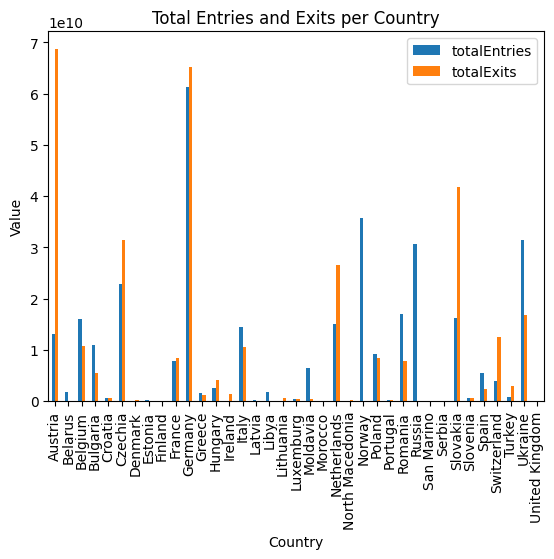

In [171]:
import matplotlib.pyplot as plt

# Create the bar chart
percountry_flow_df.plot(x='countryName', y=['totalEntries', 'totalExits'], kind='bar')

# Set the labels and title
plt.xlabel('Country')
plt.ylabel('Value')
plt.title('Total Entries and Exits per Country')

# Show the chart
plt.show()